In [1]:
import os
from os.path import isfile
import sys
import glob

os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import mlflow
import mlflow.tensorflow

2024-08-06 08:51:49.445600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 08:51:49.551559: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from time import perf_counter
print(perf_counter())

2229518.503874515


In [3]:
from tqdm import tqdm

In [ ]:
mlflow.tensorflow.autolog()
mlflow.set_experiment("HSEL AE")

In [ ]:
#train = ['/data/nature_run/fulldays_reduced/all_20060803.npz', '/data/nature_run/fulldays_reduced/all_20060815.npz', '/data/nature_run/fulldays_reduced/all_20060915.npz']
#test = ['/data/nature_run/fulldays_reduced/all_20060315.npz', '/data/nature_run/fulldays_reduced/all_20060515.npz', '/data/nature_run/fulldays_reduced/all_20060615.npz', '/data/nature_run/fulldays_reduced/all_20060715.npz', '/data/nature_run/fulldays_reduced/all_20061015.npz', '/data/nature_run/fulldays_reduced/all_20061115.npz', '/data/nature_run/fulldays_reduced/all_20061215.npz']

#print(len(train), len(test), len(train)+ len(test)) 


In [4]:
files = glob.glob("/data/nature_run/fulldays_reduced_evenmore/*.npz")
print(files)

['/data/nature_run/fulldays_reduced_evenmore/all_20060915.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060815.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060615.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061015.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060515.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060715.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060803.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061115.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060315.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061215.npz']


In [ ]:
train1 = '/data/nature_run/fulldays_reduced_evenmore/all_20060815.npz'
train2 = '/data/nature_run/fulldays_reduced_evenmore/all_20060803.npz'
train3 = '/data/nature_run/fulldays_reduced_evenmore/all_20060915.npz'
train = [train1, train2, train3]

data = []
for i in train:
    tmp = np.load(i)
    print(list(tmp.keys()))


In [ ]:

test = ['/data/nature_run/fulldays_reduced_evenmore/all_20060615.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061015.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060515.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060715.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061115.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20060315.npz', '/data/nature_run/fulldays_reduced_evenmore/all_20061215.npz']


In [5]:
start = perf_counter()

hsel_train = []
for i in tqdm(files):
    tmp = np.load(i)
    hsel_train.append(tmp["hsel"])

hsel_train = np.vstack(hsel_train)

end = perf_counter()

print(hsel_train.shape)
print(end-start)

100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.89s/it]


(9712457, 1957)
333.7047240990214


In [6]:
mins = np.min(hsel_train, axis=0)
maxs = np.max(hsel_train, axis=0)
np.savez("minimac_scaling_factors_hsel.npz", mins=mins, maxs=maxs)

In [39]:
a = np.ones((10,10,6))
print(np.average(a, axis=2).shape)

(10, 10)


In [ ]:
means = np.mean(hsel_train, axis=0)
stds = np.std(hsel_train, axis=0)

print(means.shape, stds.shape)

In [ ]:
print(np.min(means), np.max(means), np.average(means))
print(np.min(stds), np.max(stds), np.average(stds))

In [ ]:
# Save out scaling factors
np.savez("scaling_factors_hsel.npz", means=means, stds=stds)

In [7]:
hsel_train = (hsel_train - mins)/(maxs - mins)
np.save("hsel_scaled_minimax.npy", hsel_train)

In [ ]:
hsel_train = (hsel_train-means)/stds

In [ ]:
np.save("hsel_scaled.npy", hsel_train)

In [3]:
hsel_train = np.load("hsel_scaled.npy")
print(hsel_train.shape)

(9712457, 1957)


In [4]:
# with tf.device('/cpu:0'):
#     x = tf.convert_to_tensor(hsel_train, np.float32)
# print(type(x))

2024-08-05 12:52:17.345791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 12:52:17.863947: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-08-05 12:52:17.864927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31017 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
with tf.device('/cpu:0'):
    x = tf.convert_to_tensor(x, np.float32)

In [8]:

with tf.device('/cpu:0'):
    #hsel_train = np.load("hsel_scaled.npy")
    x = tf.convert_to_tensor(hsel_train, np.float32)
print(type(x))


2024-08-06 09:18:25.254911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 09:18:25.827182: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-08-06 09:18:25.828202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31017 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# hsel_test = []
# scalar_test = []
# table_test = []

# for i in test:
#     tmp = np.load(i)
#     hsel_test.append(tmp["hsel"])
#     scalar_test.append(tmp["scalar"])
#     table_test.append(tmp["table"])

# hsel_test = np.vstack(hsel_test)
# scalar_test = np.vstack(scalar_test)
# table_test = np.vstack(table_test)

# print(hsel_test.shape, scalar_test.shape, table_test.shape)

In [9]:

def build_autoencoder(input_dim, latent_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    act = 'relu'
    #act = 'gelu'
    #act = "sigmoid"
    
    encoder = Dense(128, activation=act)(input_layer)
    encoder = Dense(100, activation=act)(encoder)
    encoder = Dense(72, activation=act)(encoder)
    
    latent_space = Dense(latent_dim, activation="linear")(encoder)

    decoder = Dense(72, activation=act)(latent_space)
    decoder = Dense(100, activation=act)(decoder)
    decoder = Dense(128, activation=act)(decoder)
    output_layer = Dense(input_dim, activation='linear')(decoder)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder_model = Model(inputs=input_layer, outputs=latent_space)

    autoencoder.compile(optimizer='adam', loss='mse')
    
    
    return autoencoder, encoder_model


In [10]:
input_dim = 1957 
latent_dim = 64  
autoencoder, encoder_model = build_autoencoder(input_dim, latent_dim)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1957)]            0         
                                                                 
 dense (Dense)               (None, 128)               250624    
                                                                 
 dense_1 (Dense)             (None, 100)               12900     
                                                                 
 dense_2 (Dense)             (None, 72)                7272      
                                                                 
 dense_3 (Dense)             (None, 64)                4672      
                                                                 
 dense_4 (Dense)             (None, 72)                4680      
                                                                 
 dense_5 (Dense)             (None, 100)               7300  

In [12]:
es = EarlyStopping(monitor='loss', patience=6, verbose=1)
mc = ModelCheckpoint(filepath="hsel_ae_eval_minimax.keras", verbose=1, monitor='loss', mode='min', save_best_only=True)



In [14]:
print(x)

tf.Tensor(
[[-3.1881974 -3.198745  -3.208634  ... -3.477102  -3.541099  -2.4749622]
 [-2.7842808 -2.793198  -2.8016233 ... -2.8952053 -2.9283347 -2.1777518]
 [-2.783676  -2.7922685 -2.8003926 ... -2.9168217 -2.943195  -2.2033303]
 ...
 [-2.3887157 -2.3931587 -2.397469  ... -2.288444  -2.2801242 -1.9656309]
 [-2.406954  -2.411262  -2.415443  ... -2.3914337 -2.379833  -1.995817 ]
 [-2.4169106 -2.4214873 -2.425916  ... -2.3657892 -2.3588033 -1.9837167]], shape=(9712457, 1957), dtype=float32)


In [13]:
history = autoencoder.fit(x, x, batch_size=1024, epochs=1000, verbose=1,
                          callbacks=[es, mc])

Epoch 1/1000
9484/9485 [============================>.] - ETA: 0s - loss: 4.6533e-04
Epoch 1: loss improved from inf to 0.00047, saving model to hsel_ae_eval_minimax.keras
9485/9485 [==============================] - 101s 10ms/step - loss: 4.6529e-04
Epoch 2/1000
5768/9485 [=================>............] - ETA: 41s - loss: 4.6314e-05

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



9485/9485 [==============================] - ETA: 0s - loss: 6.4581e-06
Epoch 17: loss improved from 0.00001 to 0.00001, saving model to hsel_ae_eval_minimax.keras
9485/9485 [==============================] - 97s 10ms/step - loss: 6.4581e-06
Epoch 18/1000
9484/9485 [============================>.] - ETA: 0s - loss: 6.1372e-06
Epoch 18: loss improved from 0.00001 to 0.00001, saving model to hsel_ae_eval_minimax.keras
9485/9485 [==============================] - 99s 10ms/step - loss: 6.1370e-06
Epoch 19/1000
9483/9485 [============================>.] - ETA: 0s - loss: 6.0977e-06
Epoch 19: loss improved from 0.00001 to 0.00001, saving model to hsel_ae_eval_minimax.keras
9485/9485 [==============================] - 97s 10ms/step - loss: 6.1008e-06
Epoch 20/1000
9480/9485 [============================>.] - ETA: 0s - loss: 5.8259e-06
Epoch 20: loss improved from 0.00001 to 0.00001, saving model to hsel_ae_eval_minimax.keras
9485/9485 [==============================] - 96s 10ms/step - loss: 5

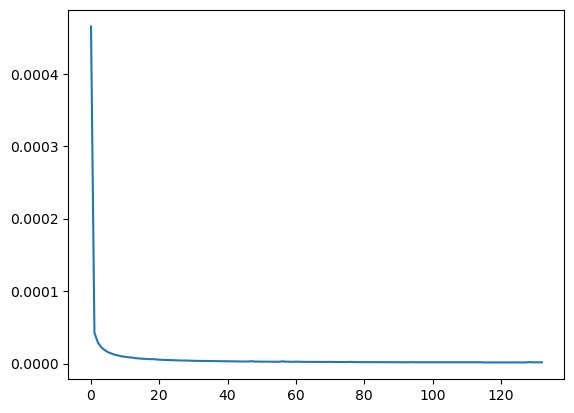

In [15]:
plt.plot(history.history["loss"])

In [16]:
#autoencoder.save("hsel_ae_eval.keras")
encoder_model.save("encoder_3_mae.keras")

In [17]:
print(autoencoder.layers[1].get_weights()[0])
print(encoder_model.layers[1].get_weights()[0])

[[ 0.04197723 -0.11006036  0.00357839 ... -0.03847643  0.00432654
  -0.04390932]
 [-0.03249782 -0.02292815  0.02850147 ...  0.0510024   0.03084978
  -0.05155373]
 [-0.05069329 -0.03299119 -0.05785642 ...  0.04341505 -0.04626712
  -0.04103879]
 ...
 [ 0.02412799 -0.1809889  -0.05857753 ... -0.01179309  0.04092099
   0.00633704]
 [-0.05699721 -0.16432264  0.0409355  ... -0.04869202 -0.01457644
  -0.02006952]
 [-0.02276465 -0.27154252 -0.01717412 ... -0.02830176 -0.01665714
  -0.02767531]]
[[ 0.04197723 -0.11006036  0.00357839 ... -0.03847643  0.00432654
  -0.04390932]
 [-0.03249782 -0.02292815  0.02850147 ...  0.0510024   0.03084978
  -0.05155373]
 [-0.05069329 -0.03299119 -0.05785642 ...  0.04341505 -0.04626712
  -0.04103879]
 ...
 [ 0.02412799 -0.1809889  -0.05857753 ... -0.01179309  0.04092099
   0.00633704]
 [-0.05699721 -0.16432264  0.0409355  ... -0.04869202 -0.01457644
  -0.02006952]
 [-0.02276465 -0.27154252 -0.01717412 ... -0.02830176 -0.01665714
  -0.02767531]]


In [4]:
#autoencoder = tf.keras.models.load_model("ae_tmp.keras")

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1957)]            0         
                                                                 
 dense (Dense)               (None, 128)               250624    
                                                                 
 dense_1 (Dense)             (None, 100)               12900     
                                                                 
 dense_2 (Dense)             (None, 72)                7272      
                                                                 
 dense_3 (Dense)             (None, 64)                4672      
                                                                 
 dense_4 (Dense)             (None, 72)                4680      
                                                                 
 dense_5 (Dense)             (None, 100)               7300  

In [13]:
print(np.max(x), np.min(x), np.mean(x), np.std(x))

32.48172 -9.937093 -1.1308387e-06 0.999974


In [19]:
x.shape[0]
ind = np.random.choice(x.shape[0], size=10000, replace=False)
print(ind)

[4997614  624564 5372020 ... 7711677 1031606 3626201]


tf.Tensor(
[[-3.1881974 -3.198745  -3.208634  ... -3.477102  -3.541099  -2.4749622]
 [-2.7842808 -2.793198  -2.8016233 ... -2.8952053 -2.9283347 -2.1777518]
 [-2.783676  -2.7922685 -2.8003926 ... -2.9168217 -2.943195  -2.2033303]
 ...
 [-2.3887157 -2.3931587 -2.397469  ... -2.288444  -2.2801242 -1.9656309]
 [-2.406954  -2.411262  -2.415443  ... -2.3914337 -2.379833  -1.995817 ]
 [-2.4169106 -2.4214873 -2.425916  ... -2.3657892 -2.3588033 -1.9837167]], shape=(9712457, 1957), dtype=float32)


In [20]:
#x_true = x[ind]
x_pred = autoencoder.predict(hsel_train[ind], batch_size=100)

100/100 [==============================] - 0s 2ms/step


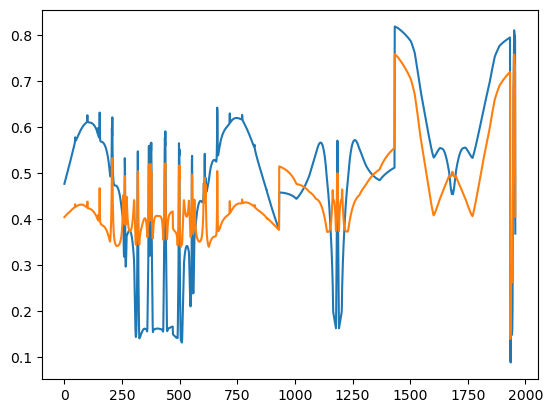

In [36]:
a = np.random.randint(x_pred.shape[0])
plt.plot(hsel_train[a])
plt.plot(x_pred[a])


In [17]:
autoencoder.save("ae_tmp.keras")

In [ ]:
# create validation set

In [ ]:
x_train = hsel_train


In [ ]:
num_rows = hsel_train.shape[0]
num_chunks = 10

chunksize = int(num_rows/num_chunks)

for i in range(num_chunks):
    print(i*chunksize,(i+1)*chunksize)

In [ ]:

input_dim = 1957 
latent_dim = 40  
autoencoder, encoder_model = build_autoencoder(input_dim, latent_dim)
autoencoder.summary()
encoder_model.summary()


In [ ]:
num_rows = hsel_train.shape[0]
num_chunks = 10
chunksize = int(num_rows/num_chunks)
indices = []
for i in range(num_chunks):
    indices.append(np.r_[i*chunksize:(i+1)*chunksize])

In [ ]:
type(indices)
print(len(indices))


In [ ]:
print(indices)

In [ ]:
np.random.choice(indices, size=num_chunks)

In [ ]:
epochs = 10
for _ in range(epochs):
    np.random.shuffle(indices)
    for i in indices:  
        autoencoder.fit(hsel_train[i], 
                        hsel_train[i], batch_size=1000, epochs=1)

In [ ]:
pred = autoencoder.predict(hsel_train, batch_size=10000)


In [ ]:
pred_test = autoencoder.predict(hsel_test, batch_size=10000)


In [ ]:
plt.plot(pred[100000, :])
plt.plot(hsel_train[100000, :])

In [ ]:
plt.plot(pred_test[10000, :])
plt.plot(hsel_test[10000, :])

In [ ]:
encoder_model.summary()
encoder_model.save("encoder.keras")

In [ ]:
all_times = ['20060315', '20060515', '20060615', '20060715', '20060803', '20060815', '20060915', '20061015', '20061115', '20061215']
print()

In [ ]:
plt.plot(history.history["loss"])


In [ ]:
base = "/data/nature_run/fulldays"
hsel = "hympi_20060315.npz"
nrun = "Nature_20060315.npz"

In [ ]:
hsel_file = np.load(f"{base}/{hsel}")
hsel_keys = sorted(list(hsel_file.keys()))
print(hsel_keys)
hsel_data = [hsel_file[x] for x in hsel_keys]
nrun_data = np.load(f"{base}/{nrun}")
nrun_tab = nrun_data["table"]
nrun_sca = nrun_data["scalar"]

In [ ]:
for i, j in zip(hsel_keys, hsel_data):
    print(i, j.shape)

In [ ]:
print(np.max(hsel_data[1]), np.min(hsel_data[1]))

In [ ]:
cf = nrun_sca[:, 24]
spress = nrun_sca[:, 2]

allowed_cf = float(0.1)
indices = cf <= allowed_cf

print(len(indices))
#x_scaler = MinMaxScaler()
#x = x_scaler.fit_transform(atms_data[indices])
#x_scalerp = MinMaxScaler()
#x_pressure = x_scalerp.fit_transform(spress[indices].reshape(-1, 1))

#water_vapor = 2
#temperature = 1
x = [hsel_data[0][indices]/300,
     hsel_data[1][indices]/300,
     hsel_data[2][indices]/300,
     hsel_data[3][indices]/300,
     hsel_data[4][indices]/300,
     hsel_data[5][indices]/300]
y = nrun_tab[indices, :, 1]

In [ ]:
for i in x:
    print(i.shape)

In [ ]:
x_all = np.hstack(x)
print(x_all.shape)

In [ ]:
#np.save("hsel_20060315.npy", x_all)
#np.save("t_20060315.npy", y)

In [ ]:
x = np.load("hsel_20060315.npy")
y = np.load("t_20060315.npy")

In [ ]:
print(x.shape, y.shape)

In [ ]:
split = int(x.shape[0]*0.80)
x_train = x[:split]
y_train = y[:split]

x_test = x[split:]
y_test = y[split:]

In [ ]:
model = build_model()


In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_split=0.1)


In [ ]:
losses =[]


In [ ]:
batch_size = 25000
epochs = 25
# Train the model using train_on_batch
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    num_batches = int(np.ceil(x_train.shape[0] / batch_size))
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        loss = model.train_on_batch(x_batch, y_batch)
        losses.append(loss)
    print(f"Epoch {epoch} - Loss: {loss:.4f}")

# Evaluate the model on the test set
#print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [ ]:
test_pred = model.predict(test_dataset, verbose=1)
train_pred = model.predict(train_dataset, verbose=1)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
index = 1000
#plt.plot(pred[index])
#plt.plot(y_test[index])
for i in range(100):
    plt.plot(test_pred[index+i*1000])
plt.plot()

In [ ]:
y = train_dataset.take(1)


In [ ]:
for i in y:
    print(i)

In [ ]:
index = 1000
#plt.plot(pred[index])
#plt.plot(y_test[index])
for i in range(10):
    plt.plot(train_pred[index+i])
plt.plot(y_train[index])